
### events

In [36]:
import pandas as pd

d = pd.read_csv('Trainingdata2.csv')
events = set(d['event'])
print(events)

{'international_expo', 'ramadan_eid_rush', 'dubai_shopping_festival', 'oil_price_surge', 'midterm_break', 'air_show', 'christmas_season', 'expo_2020', 'hajj_season', 'royal_wedding', 'international_day_of_happiness', 'dubai_marathon', 'new_years_eve', 'world_cup', 'new_year', 'national_day_rush', 'economic_slowdown', 'shopping_festival', 'spring_season', 'comicon_dubai', 'eid_al_fitr', 'international_food_festival', 'corona', 'uae_national_day', 'dubai_new_year', 'art_dubai', 'spring_break', 'formula_1_grand_prix', 'national_day_celebration', 'ramadan', 'diwali', 'winter_holiday_season', 'eid_al_adha', 'global_financial_tension', 'pre_hajj_season', 'summer_season', 'ramadan_season'}


In [ ]:
# Holidays (Recurring Events)
holidays = [
    'Ramadan',
    'Eid al-Fitr',
    'Eid al-Adha',
    'UAE National Day',
    'Christmas Season',
    'New Year\'s Eve',
    'Diwali',
    'Dubai Shopping Festival',
    'Spring Break',
    'Winter Holiday Season',
    'Dubai New Year'
]

non_recurrent_events = [
    'International Expo',
    'Oil Price Surge',
    'Midterm Break',
    'Air Show',
    'Expo 2020',
    'Hajj Season',
    'Royal Wedding',
    'International Day of Happiness',
    'Dubai Marathon',
    'World Cup',
    'Economic Slowdown',
    'Shopping Festival',
    'Comicon Dubai',
    'Global Financial Tension',
    'Pre-Hajj Season',
    'Formula 1 Grand Prix'
]


### transformation

In [1]:
import pandas as pd

df = pd.read_csv('Trainingdata2.csv')

df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

df['year'] = df['start_date'].dt.year


df['arrival_pct_change_lag1'] = df.groupby(['event'])['arrival_percentage_change'].shift(1)

df['mean'] = df.groupby('event')['arrival_percentage_change'].transform('mean')
df['arrival_pct_change_lag1'].fillna(df['mean'], inplace=True)

df = pd.get_dummies(df, columns=['event'], prefix='event')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15176\3758586200.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['arrival_pct_change_lag1'].fillna(df['mean'], inplace=True)


### LASSO

In [6]:
from sklearn.linear_model import Lasso

df = pd.read_csv('transformed.csv')
y = df['arrival_percentage_change']
X=df.drop(columns=['arrival_percentage_change','departure_percentage_change','start_date'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = Lasso(alpha=1)
model.fit(X, y)

Lasso(alpha=1)

In [9]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd 

df = pd.read_csv('transformed.csv')
y = df['arrival_percentage_change']
X=df.drop(columns=['arrival_percentage_change','departure_percentage_change','start_date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_L = Lasso(alpha=0.5)

model_L.fit(X_train, y_train)

y_pred = model_L.predict(X_test)
y_2 = model_L.predict(X)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)



Mean Squared Error: 15.170934051080359
R-squared: 0.8463201564608113


### prophet + regressors 

In [12]:
import pandas as pd
from prophet import Prophet
from sklearn.model_selection import train_test_split

df = pd.read_csv('transformed.csv')


prophet_data = df[['start_date', 'arrival_percentage_change']].rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'})

prophet_data = prophet_data.join(df.filter(like='percentage_change_lag1'))
prophet_data = prophet_data.join(df.filter(like='event_'))  # Join all event dummies


model = Prophet()

model.add_regressor('arrival_percentage_change_lag1')

for column in df.filter(like='event_').columns:
    model.add_regressor(column)

model.fit(prophet_data)

04:01:32 - cmdstanpy - INFO - Chain [1] start processing
04:01:32 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
new_prophet_data = df.rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'})
forecast = model.predict(new_prophet_data)

results = new_prophet_data[['ds', 'y']].copy()  
results['yhat'] = forecast['yhat']
results['yhat_lower'] = forecast['yhat_lower']
results['yhat_upper'] = forecast['yhat_upper']

r2 = r2_score(results['y'], results['yhat'])
print(f'R² Score: {r2}')

R² Score: -0.8832782941717208


### Prophet the ml (2 models)

In [14]:
import pandas as pd
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

df = pd.read_csv('transformed.csv')

df=df.drop(columns=['departure_percentage_change'])


prophet_df = df[['start_date', 'arrival_percentage_change']].rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future =df[['start_date', 'arrival_percentage_change']].rename(columns={'start_date': 'ds'})
forecast = prophet_model.predict(future)
df['start_date'] = pd.to_datetime(df['start_date'])
dff = df.merge(forecast[['ds', 'yhat']], left_on='start_date', right_on='ds', how='left')
mae = r2_score(dff['arrival_percentage_change'], dff['yhat'])
print(f'R2: {mae}')

X = dff.drop(columns=['arrival_percentage_change','start_date','ds'])
y = dff['arrival_percentage_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae = r2_score(y_test, y_pred)
print(f'R2: {mae}')

# Combine Predictions (if needed)
X_= dff.drop(columns=['arrival_percentage_change','start_date','ds'])
y_pred2 = rf_model.predict(X_)


final_predictions = (y_pred2 + dff['yhat'].values) / 2  # Average predictions
mae = r2_score(dff['arrival_percentage_change'],final_predictions)
print(f'R2: {mae}')


04:01:49 - cmdstanpy - INFO - Chain [1] start processing
04:01:49 - cmdstanpy - INFO - Chain [1] done processing


R2: 0.4942402508672791
R2: 0.8929535488294751
R2: 0.8480890091564367


In [ ]:
df = pd.read_csv('test.csv',parse_dates=[1])

df=df.drop(columns=['departure_percentage_change','end_date'])
df = df.rename(columns={'start_date': 'ds'})
df['yhat'] = prophet_model.predict(df)['yhat']

df['final_predictions'] = rf_model.predict(df.drop(columns=['arrival_percentage_change','ds']))
r222 = r2_score(df['arrival_percentage_change'],df['final_predictions'])
print(r222)






In [55]:
df[['year','arrival_percentage_change','yhat','arrival_pct_change_lag1','final_predictions']].to_csv('pp.csv',index=False)

## Supervised 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
df = pd.read_csv('transformed.csv')
features = df[['year', 'arrival_percentage_change_lag1','mean_change'] + 
              [col for col in df.columns if col.startswith('event_')]]
target = df['arrival_percentage_change']  

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)




### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd 

df = pd.read_csv('transformed.csv')
y = df['arrival_percentage_change']
X=df.drop(columns=['arrival_percentage_change','departure_percentage_change','start_date'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

y_pred = model_LR.predict(X_test)
y_2 = model_LR.predict(X)
df['pred']= y_2

df[['arrival_percentage_change','pred']].to_csv('pred.csv',index=False)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_2 = r2_score(df['arrival_percentage_change'],df['pred'])

print(r2_2)
print("Mean Squared Error:", mse)
print("R-squared:", r2)



-7.379370573152486e+18
Mean Squared Error: 7.414277004063276e+21
R-squared: -5.3776761560200135e+19


In [ ]:
dff=pd.read_csv('pred.csv')
r2_2 = r2_score(dff['arrival_percentage_change'],dff['pred'])
print(r2_2)

### Random Forest 

In [18]:
###
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2: {r2}")

Mean Absolute Error: 4.477321064886578
Root Mean Squared Error: 7.162459251506989
R2: 0.6279081426956333


In [ ]:
df = pd.read_csv('test.csv',parse_dates=[1])

df_=df[['year', 'arrival_pct_change_lag1','mean'] + 
              [col for col in df.columns if col.startswith('event_')]]

df['final_predictions'] = model.predict(df_)
r222 = r2_score(df['arrival_percentage_change'],df['final_predictions'])
print(r222)






### SVR

In [20]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv('transformed.csv')

X = data.drop(columns=['start_date', 'arrival_percentage_change','departure_percentage_change'])
y = data['arrival_percentage_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_model = SVR()
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
print("\nSupport Vector Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_svr))
print("R^2:", r2_score(y_test, y_pred_svr))


Support Vector Regression:
MSE: 97.2260691041022
R^2: -0.019209952483595583


### Decision Tree 

In [21]:

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
print("\nDecision Tree Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_tree))
print("R^2:", r2_score(y_test, y_pred_tree))


Decision Tree Regression:
MSE: 29.724618925996474
R^2: 0.6884001613731845


### lgbm 

In [23]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

lgb_model = lgb.train(params, lgb_train, num_boost_round=100)
y_pred = lgb_model.predict(X_test)
print("LightGBM Regression:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 3
[LightGBM] [Info] Start training from score 7.213177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

### k-cross validation

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.linear_model import Lasso


data = pd.read_csv('transformed.csv')

X = data.drop(columns=['start_date', 'arrival_percentage_change','departure_percentage_change'])
y = data['arrival_percentage_change']

models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Lasso':Lasso(alpha=1)
}

k = 5  
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=k, scoring='r2')
    mean_r2 = np.mean(cv_scores)
    print(f"{model_name}:")
    print(f"Mean R²: {mean_r2:.4f}")


Linear Regression:
Mean R²: -52386095192586577772544.0000
Support Vector Regression:
Mean R²: -0.0511
Decision Tree Regression:
Mean R²: 0.4183
Lasso:
Mean R²: 0.8471


## Time Series models

### Prophet with events as regressors 

04:06:14 - cmdstanpy - INFO - Chain [1] start processing
04:06:14 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'event_air_show',
       ...
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object', length=133)
Mean Squared Error: 12.163978060584798
R^2 Score: 0.6199190440773635


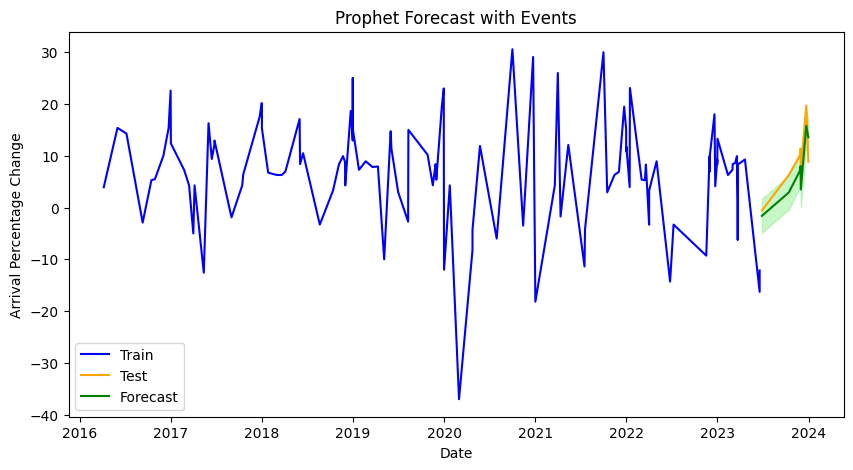

In [28]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load and prepare the dataset
data = pd.read_csv('transformed.csv')
data = data.sort_values(by='start_date')

# Convert 'start_date' to datetime
data['start_date'] = pd.to_datetime(data['start_date'])

# Rename columns for Prophet
data.rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'}, inplace=True)


# Step 3: Train-test split
train_size = int(len(data) * 0.95)  # 80% for training
train_data = data[:train_size]
test_data = data[train_size:]

prophet_model = Prophet()

for col in train_data.columns:
    if col.startswith('event_'):
        prophet_model.add_regressor(col)

prophet_model.fit(train_data)

future_data =test_data



# Forecast
forecast = prophet_model.predict(future_data)
print(forecast.columns)

# Step 6: Evaluate the model
mse = mean_squared_error(test_data['y'], forecast['yhat'])
r2 = r2_score(test_data['y'], forecast['yhat'])

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_data['ds'], train_data['y'], label='Train', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='lightgreen', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Arrival Percentage Change')
plt.title('Prophet Forecast with Events')
plt.legend()
plt.show()


### ED

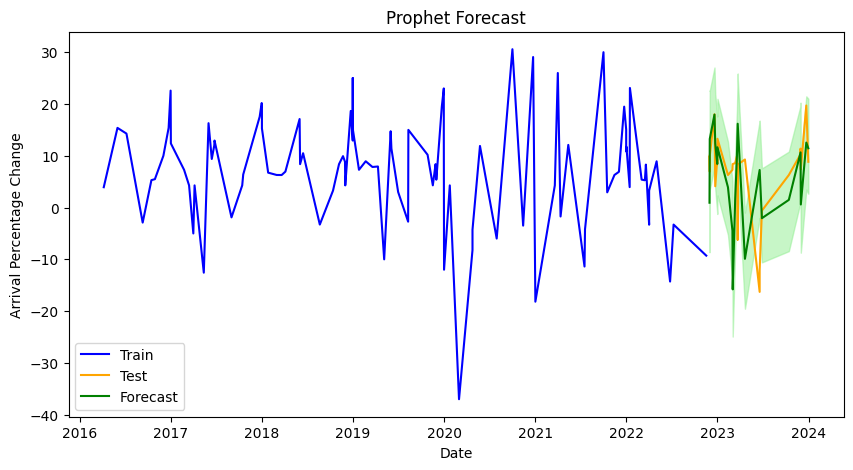

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_data['ds'], train_data['y'], label='Train', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test', color='orange')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='green')
plt.fill_between(forecast_test['ds'], 
                 forecast_test['yhat_lower'], 
                 forecast_test['yhat_upper'], 
                 color='lightgreen', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Arrival Percentage Change')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

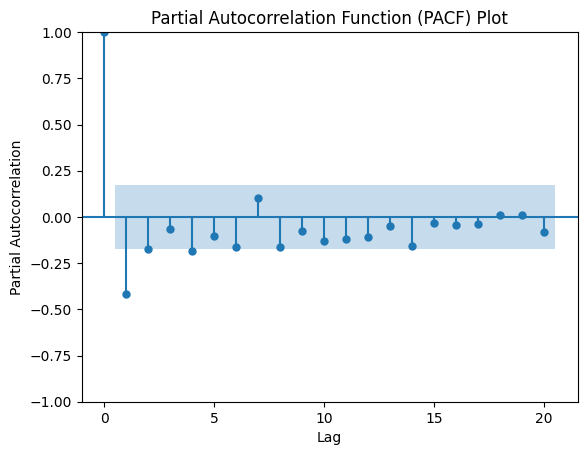

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

data = pd.read_csv('transformed.csv')
data['start_date'] = pd.to_datetime(data['start_date'])
data.set_index('start_date', inplace=True)
y = data['arrival_percentage_change']

plt.figure(figsize=(10, 6))
plot_pacf(y.diff().dropna(), lags=20, method='ywm') 
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.title("Partial Autocorrelation Function (PACF) Plot")
plt.show()


<Figure size 1000x600 with 0 Axes>

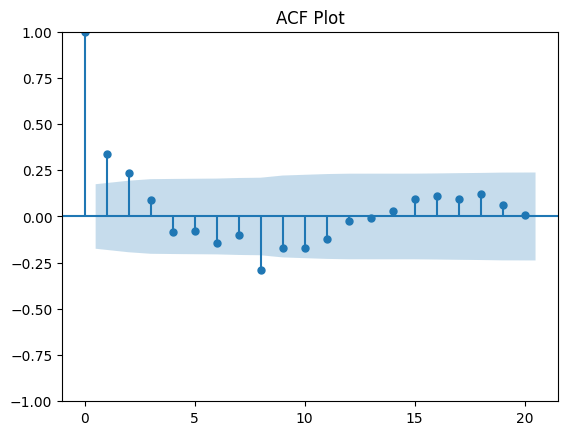

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
data = pd.read_csv('transformed.csv')
data['start_date'] = pd.to_datetime(data['start_date'])
data.set_index('start_date', inplace=True)
y = data['arrival_percentage_change']

plt.figure(figsize=(10, 6))
plot_acf(y, lags=20) 
plt.title('ACF Plot')
plt.show()


### Arima 

In [30]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv('transformed.csv')

data['start_date'] = pd.to_datetime(data['start_date'])
data = data.sort_values(by='start_date')

data.set_index('start_date', inplace=True)

y = data['arrival_percentage_change']

train_size = int(len(y) * 0.8)  
train, test = y[:train_size], y[train_size:]

arima_model = ARIMA(train, order=(1, 0, 1)) 
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(test))
print("ARIMA Model:")
print("Mean Squared Error:", mean_squared_error(test, arima_forecast))
print("R^2 Score:", r2_score(test, arima_forecast))

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model:
Mean Squared Error: 62.32220548432221
R^2 Score: -0.029507745173962263


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Exponential Smoothing

In [31]:
exp_smoothing_model = ExponentialSmoothing(train, trend='add', seasonal=None, seasonal_periods=None)
exp_fit = exp_smoothing_model.fit()
exp_forecast = exp_fit.forecast(steps=len(test))
print("\nExponential Smoothing Model:")
print("Mean Squared Error:", mean_squared_error(test, exp_forecast))
print("R^2 Score:", r2_score(test, exp_forecast))


Exponential Smoothing Model:
Mean Squared Error: 66.39189587117872
R^2 Score: -0.09673543298072285


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Prophet with all events set as holidays (not logical just a trial)

21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing


0.9967268078913988


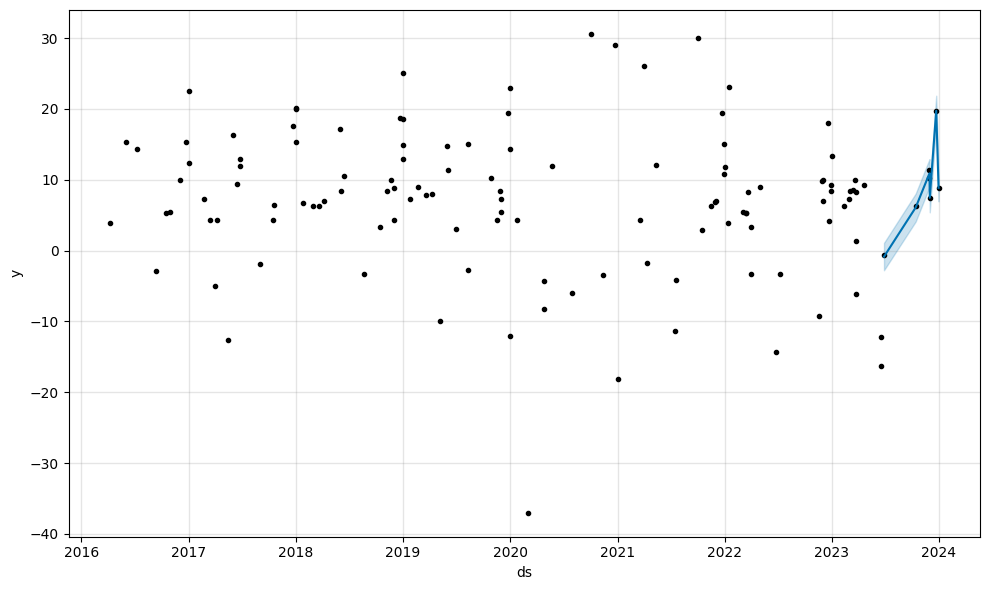

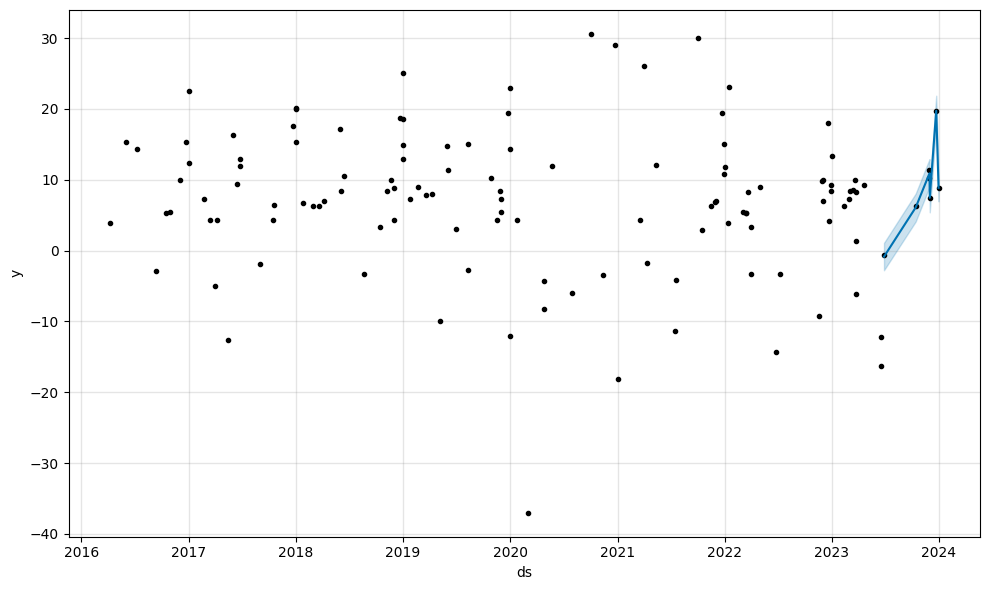

In [32]:
from prophet import Prophet

df = pd.read_csv('hh_further_expanded.csv')
df = df.sort_values(by='start_date')

# Prepare the data for Prophet
prophet_df = df[['start_date', 'arrival_percentage_change']].rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'})
train_size = int(len(prophet_df) * 0.95)  # 80% for training
train_data = prophet_df[:train_size]
test_data = prophet_df[train_size:]

prophet_model = Prophet()
events = pd.DataFrame({
    'holiday': df['event'],
    'ds': pd.to_datetime(df['start_date']),
    'lower_window': 0,
    'upper_window': (pd.to_datetime(df['end_date']) - pd.to_datetime(df['start_date'])).dt.days
})

model = Prophet(holidays=events)
model.fit(prophet_df)

future =test_data
forecast = model.predict(future)

r2 = r2_score(test_data['y'],forecast['yhat'])
print(r2)
# Plot forecast
model.plot(forecast)


### Prophet with both holidays and regressors 

23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 19.717452729228533
R^2 Score: 0.80979211628976


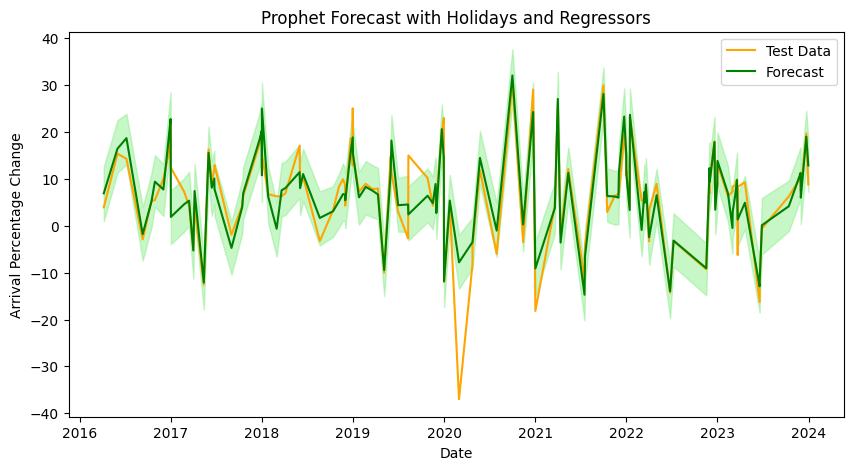

In [70]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv('hh_further_expanded.csv')
data = data.sort_values(by='start_date')
holiday_events = [ 'uae_national_day', 
    'christmas_season', 'new_years_eve', 'diwali', 
    'dubai_shopping_festival', 'spring_break', 'winter_holiday_season', 'dubai_new_year'
]
events = data[data['event'].isin(holiday_events)]
holidays_data = pd.DataFrame({
    'holiday': events['event'],
    'ds': events['start_date'],
    'lower_window': 0,
    'upper_window': (pd.to_datetime(events['end_date']) - pd.to_datetime(events['start_date'])).dt.days
})

non_recurrent_events = ['ramadan', 'eid_al_fitr', 'eid_al_adha',
    'international_expo', 'oil_price_surge', 'midterm_break', 'air_show', 
    'expo_2020', 'hajj_season', 'royal_wedding', 'international_day_of_happiness', 
    'dubai_marathon', 'world_cup', 'economic_slowdown', 'shopping_festival', 
    'comicon_dubai', 'global_financial_tension', 'pre_hajj_season', 'formula_1_grand_prix'
]

for event in non_recurrent_events:
    data[event] = data['event'].isin([event]).astype(int)

data.rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'}, inplace=True)

data['ds'] = pd.to_datetime(data['ds'])

#train_size = int(len(data) * 0.8)  
#train_data = data[:train_size]
#test_data = data[train_size:]

prophet_model = Prophet(holidays=holidays_data)
for event in non_recurrent_events:
    prophet_model.add_regressor(event)

prophet_model.fit(data)

future_data = data.copy()

forecast = prophet_model.predict(future_data)
forecast['ds'] = pd.to_datetime(forecast['ds'])
mse = mean_squared_error(data['y'], forecast['yhat'])
r2 = r2_score(data['y'], forecast['yhat'])
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
test_data = data.copy()
plt.figure(figsize=(10, 5))
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='orange')

plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='lightgreen', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Arrival Percentage Change')
plt.title('Prophet Forecast with Holidays and Regressors')
plt.legend()
plt.show()


In [69]:
data = pd.read_csv('Test.csv')
data = data.sort_values(by='start_date')

non_recurrent_events = ['ramadan', 'eid_al_fitr', 'eid_al_adha',
    'international_expo', 'oil_price_surge', 'midterm_break', 'air_show', 
    'expo_2020', 'hajj_season', 'royal_wedding', 'international_day_of_happiness', 
    'dubai_marathon', 'world_cup', 'economic_slowdown', 'shopping_festival', 
    'comicon_dubai', 'global_financial_tension', 'pre_hajj_season', 'formula_1_grand_prix'
]

for event in non_recurrent_events:
    data[event] = data['event'].isin([event]).astype(int)

data.rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'}, inplace=True)

data['ds'] = pd.to_datetime(data['ds'])

forecast = prophet_model.predict(data)
print(forecast['yhat'])
mse = mean_squared_error(data['y'], forecast['yhat'])
r2 = r2_score(data['y'], forecast['yhat'])

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


0   -164.388154
1   -242.841212
Name: yhat, dtype: float64
Mean Squared Error: 44912.69919407817
R^2 Score: -109.20773161129321


In [61]:
data = pd.read_csv('hh_further_expanded.csv')
data = data.sort_values(by='start_date')



non_recurrent_events = ['ramadan', 'eid_al_fitr', 'eid_al_adha',
    'international_expo', 'oil_price_surge', 'midterm_break', 'air_show', 
    'expo_2020', 'hajj_season', 'royal_wedding', 'international_day_of_happiness', 
    'dubai_marathon', 'world_cup', 'economic_slowdown', 'shopping_festival', 
    'comicon_dubai', 'global_financial_tension', 'pre_hajj_season', 'formula_1_grand_prix'
]

for event in non_recurrent_events:
    data[event] = data['event'].isin([event]).astype(int)

data.rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'}, inplace=True)

data['ds'] = pd.to_datetime(data['ds'])

forecast = prophet_model.predict(data)
print(forecast['yhat'])
mse = mean_squared_error(data['y'], forecast['yhat'])
r2 = r2_score(data['y'], forecast['yhat'])

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


0       6.109667
1      17.629078
2      19.469187
3       0.103841
4       5.311661
         ...    
121    14.661666
122     8.000137
123     1.507581
124    14.468229
125    15.973535
Name: yhat, Length: 126, dtype: float64
Mean Squared Error: 34.01879872611694
R^2 Score: 0.6718316609697036


In [18]:
test = df[['start_date']].rename(columns={'start_date': 'ds', 'arrival_percentage_change': 'y'})
forecast = model.predict(test)
# Assuming 'forecast' has a 'yhat' column for predictions
predictions = forecast[['ds', 'yhat']].merge(df[['start_date', 'arrival_percentage_change']], left_on='ds', right_on='start_date', how='left')


In [ ]:
predictions

In [ ]:
from sklearn.metrics import r2_score

r_squared = r2_score(predictions['arrival_percentage_change'], predictions['yhat'])
print(f'R-squared: {r_squared}')


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(predictions['start_date'], predictions['arrival_percentage_change'], label='Actual', color='blue')
plt.plot(predictions['start_date'], predictions['yhat'], label='Predicted', color='orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Arrival Percentage Change')
plt.title('Actual vs Predicted Arrival Percentage Change')
plt.show()


In [ ]:
t= pd.read_csv('test.csv',parse_dates=[0])
a=model.predict(t)
print(a['yhat'])

## Reinforcement LEarning 

In [37]:
import gym
from gym import spaces
import numpy as np 
import pandas as pd 

class FlightEnv(gym.Env):
    def __init__(self, df,target,seed):
        super(FlightEnv, self).__init__() 
        self.df = df
        self.state_dim = df.shape[1] - 1
        self.target = target 
        self.current_step = 0 
        self.action_space = spaces.Box(low=-1.0, high=+1.0, shape=(1,), dtype=np.float32)  #it can  predict from -100% to 100%
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_dim,), dtype=np.float32)
        self.seed(seed)

    def reset(self):
        self.current_step = 0  
        return self.df.iloc[self.current_step, :-1].values

    
    def step(self, action):
       
        actual_change = self.df.loc[self.current_step, f'{self.target}_percentage_change']
        prediction = action[0] * 100  
        reward = -np.square(prediction - actual_change) 
        self.render()
        print(f"the prediction is {prediction} while the actual is {actual_change}")
        print (f"The reward is {reward}")
        # Move to the next flight (step)
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        next_state = self.df.iloc[self.current_step, :-1].values if not done else np.zeros(self.state_dim)
        
        return next_state, reward, done, {}

    def render(self):
        print(f"Step: {self.current_step}")
        #print(f"Current Flight Data: {self._get_observation()}")

    def seed(self, seed=None):
        np.random.seed(seed)

In [38]:
import pandas as pd
data = pd.read_csv('testtt.csv')
data = data.drop(columns=['departure_percentage_change','start_date','end_date'])
env = FlightEnv(data,'arrival',42)

In [ ]:
from stable_baselines3 import SAC

print("Training A2C Model...")
model_sac = SAC('MlpPolicy', env, verbose=1)
#train_model(model_a2c, env, num_episodes=50)  # Training
model_sac.learn(total_timesteps=10000)

In [ ]:
from stable_baselines3 import A2C

print("Training A2C Model...")
model_a2c = A2C('MlpPolicy', env, verbose=1)
#train_model(model_a2c, env, num_episodes=50)  # Training
model_a2c.learn(total_timesteps=10000)

In [ ]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

In [ ]:
features = pd.read_csv('testtt.csv')
features_for_prediction = features.drop(columns=['arrival_percentage_change','departure_percentage_change','start_date','end_date'])
percentage_changes = []
for index, row in features_for_prediction.iterrows():
    row = row.to_numpy(dtype=np.float32) 
    percentage_change = model_sac.predict(row)
    percentage_changes.append(percentage_change[0]*100)

features[f'predicted__percentage_change'] = percentage_changes
features.to_csv(f'serving__prediction.csv', index=False)

y_test = features['arrival_percentage_change']
y_pred = features['predicted__percentage_change']


r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2*100)


### iss

In [ ]:
# Creating a bar chart for arrival and departure percentage changes across events
import matplotlib.pyplot as plt
import pandas as pd 

df = pd.read_csv('hh_further_expanded.csv')
# Plotting
plt.figure(figsize=(14, 8))
width = 0.35  # Width of the bars

# Setting positions for the bars
x = range(len(df))

# Plotting Arrival Percentage Change
plt.bar(x, df['arrival_percentage_change'], width=width, label='Arrival Percentage Change', color='skyblue', align='center')

# Plotting Departure Percentage Change, offsetting by width
plt.bar([i + width for i in x], df['departure_percentage_change'], width=width, label='Departure Percentage Change', color='salmon', align='center')

# Adding labels and title
plt.xlabel('Event')
plt.ylabel('Percentage Change (%)')
plt.title('Arrival and Departure Percentage Change Across Events')
plt.xticks([i + width / 2 for i in x], df['event'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import lightgbm as lgb
import pandas as pd 
from sklearn.model_selection import train_test_split

df = pd.read_csv('en.csv')
# Assuming df is your DataFrame
X = df.drop(columns=['arrival_percentage_change','departure_percentage_change'])
y = df['arrival_percentage_change']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train the model
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)


In [ ]:
# Make predictions
X_new = X
predictions = model.predict(X_new)

# Add predictions to the DataFrame
df['Predicted_Event_Impact'] = predictions

df.to_csv('kd.csv',index=False)
from sklearn.metrics import r2_score
import pandas as pd 

#dff=pd.read_csv('C:\\Users\\Lenovo\\Desktop\\LastReinforcementLearning\\TimeSeriesForecasting\\newedw.csv')

y_test = df['arrival_percentage_change']
y_pred = df['Predicted_Event_Impact']

#n = dff[['arrival_percentage_change','predicted_change']]
#n.to_csv('d.csv',index=False)
#y_test = n['arrival_percentage_change']
#y_pred = n['predicted_change']
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2*100)
#print(list(y_test))
#print(list(y_pred))
